In [2]:
import pandas as pd
import DataHandler
from ModelController import ModelController
from ModelNames import ModelName
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from xgboost import XGBRanker
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np


C:\Users\leoli\miniconda3\envs\RecSysFramework\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
C:\Users\leoli\miniconda3\envs\RecSysFramework\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
URM_all_dataframe = pd.read_csv(filepath_or_buffer="Data/data_train.csv",
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                engine='python')
users = pd.read_csv(filepath_or_buffer="Data/data_target_users_test.csv")

ICM = pd.read_csv(filepath_or_buffer="Data/data_ICM_metadata.csv",
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

In [4]:
URM_all, ICM_all = DataHandler.create_urm_icm(URM_all_dataframe, ICM)

controller = ModelController()

EvaluatorHoldout: Ignoring 433 ( 1.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 161 ( 0.5%) Users that have less than 1 test interactions


In [5]:
from Recommenders.ScoresHybridRecommender import ScoresHybridRecommender
from EASE_R_Recommender import EASE_R_Recommender
from Recommenders.HybridOptunable2 import HybridOptunable2

slim1 = SLIMElasticNetRecommender(controller.URM_train)
slim1.load_model(folder_path="_saved_models", file_name="SLIMtrain")
stacked = sps.vstack([0.6814451172353111 * controller.URM_train, (1 - 0.6814451172353111) * controller.ICM_all.T]).tocsr()
slim2 = SLIMElasticNetRecommender(stacked)
slim2.load_model(folder_path="_saved_models", file_name="SLIMstackedTrainval1")
bestrp3 = RP3betaRecommender(controller.URM_train)
bestrp3.load_model(folder_path="_saved_models", file_name="rp3train")
hyb1 = HybridOptunable2(controller.URM_train)
hyb1.fit(0.27959722573911727,slim1,slim2)
ease1 = EASE_R_Recommender(controller.URM_train)
ease1.load_model(folder_path="_saved_models", file_name="easetrain")
hyb2 = HybridOptunable2(controller.URM_train)
hyb2.fit(0.18923840370620948,hyb1,bestrp3)
hyb3 = ScoresHybridRecommender(controller.URM_train, ease1, hyb2, bestrp3, slim1, slim1)
alpha=0.689217356
hyb3.fit(alpha,1-alpha,0,0,0)

SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIMtrain'
SLIMElasticNetRecommender: Loading complete
SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIMstackedTrainval1'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file '_saved_modelsrp3train'
RP3betaRecommender: Loading complete
EASE_R_Recommender: Loading model from file '_saved_modelseasetrain'
EASE_R_Recommender: Loading complete


In [6]:
n_users, n_items = controller.URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
35731,NaN
35732,NaN
35733,NaN


In [7]:
cutoff = 30

for user_id in tqdm(range(n_users)):
    recommendations = hyb3.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

100%|██████████| 35736/35736 [01:32<00:00, 386.46it/s]


,ItemID
UserID,
0,14888
0,7703
0,14931
0,6348
0,572
...,...
35735,37192
35735,35753
35735,35712


In [8]:
URM_validation_coo = sps.coo_matrix(controller.URM_test)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,120
1,0,128
2,0,675
3,0,760
4,0,950
...,...,...
352916,35735,37191
352917,35735,37447
352918,35735,37503
352919,35735,37801


In [9]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,14888,left_only
1,0,7703,left_only
2,0,14931,left_only
3,0,6348,left_only
4,0,572,left_only
...,...,...,...
1072075,35735,37192,left_only
1072076,35735,35753,left_only
1072077,35735,35712,left_only
1072078,35735,37304,left_only


In [10]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,14888,False
1,0,7703,False
2,0,14931,False
3,0,6348,False
4,0,572,False
...,...,...,...
1072075,35735,37192,False
1072076,35735,35753,False
1072077,35735,35712,False
1072078,35735,37304,False


In [11]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.NonPersonalizedRecommender import TopPop

top_pop = TopPop(controller.URM_train)
top_pop.fit()


item_cf = ItemKNNCFRecommender(controller.URM_train)
item_cf.load_model(folder_path="_saved_models", file_name="itemtrain")


item_cbf = ItemKNNCBFRecommender(controller.URM_train, controller.ICM_all)
item_cbf.fit()

rp3beta = RP3betaRecommender(controller.URM_train)
rp3beta.load_model(folder_path= "_saved_models",file_name="rp3train")

slimbpr = SLIM_BPR_Cython(controller.URM_train)
slimbpr.load_model(folder_path= "_saved_models",file_name="bprtrain")


other_algorithms = {
    "top_pop": top_pop,
    "item_cf": item_cf,
    "item_cbf": item_cbf,
    "rp3beta": rp3beta,
    "SLIM_BPR": slimbpr
}

ItemKNNCFRecommender: Loading model from file '_saved_modelsitemtrain'
ItemKNNCFRecommender: Loading complete
Cython module imported successfully.
Similarity column 38121 (100.0%), 561.93 column/sec. Elapsed time 1.13 min
RP3betaRecommender: Loading model from file '_saved_modelsrp3train'
RP3betaRecommender: Loading complete
SLIM_BPR_Recommender: Loading model from file '_saved_modelsbprtrain'
SLIM_BPR_Recommender: Loading complete


In [12]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():

        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 35736/35736 [17:13<00:00, 34.58it/s]


,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR
0,0,14888,False,84.0,0.596443,0.000000,0.329630,0.843104
1,0,7703,False,69.0,0.414451,0.208383,0.315615,0.877082
2,0,14931,False,84.0,0.483289,0.117672,0.217824,1.250883
3,0,6348,False,211.0,0.215074,0.000000,0.193364,0.512122
4,0,572,False,78.0,0.401442,0.000000,0.153998,0.639469
...,...,...,...,...,...,...,...,...
1072075,35735,37192,False,27.0,0.234921,0.000000,0.093568,0.642780
1072076,35735,35753,False,22.0,0.337339,0.156480,0.154681,0.650875
1072077,35735,35712,False,19.0,0.273041,0.114071,0.053850,0.214327
1072078,35735,37304,False,56.0,0.000000,0.000000,0.143927,0.633242


In [13]:

'''ICM_features = controller.ICM_all.to_dict()["feature_id"]
ICM_features'''




'ICM_features = controller.ICM_all.to_dict()["feature_id"]\nICM_features'

In [14]:
item_popularity = np.ediff1d(sps.csc_matrix(controller.URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

training_dataframe

,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity
0,0,14888,False,84.0,0.596443,0.000000,0.329630,0.843104,84
1,0,7703,False,69.0,0.414451,0.208383,0.315615,0.877082,69
2,0,14931,False,84.0,0.483289,0.117672,0.217824,1.250883,84
3,0,6348,False,211.0,0.215074,0.000000,0.193364,0.512122,211
4,0,572,False,78.0,0.401442,0.000000,0.153998,0.639469,78
...,...,...,...,...,...,...,...,...,...
1072075,35735,37192,False,27.0,0.234921,0.000000,0.093568,0.642780,27
1072076,35735,35753,False,22.0,0.337339,0.156480,0.154681,0.650875,22
1072077,35735,35712,False,19.0,0.273041,0.114071,0.053850,0.214327,19
1072078,35735,37304,False,56.0,0.000000,0.000000,0.143927,0.633242,56


In [15]:
type(training_dataframe["ItemID"])

pandas.core.series.Series

In [16]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity
0,0,14888,False,84.0,0.596443,0.000000,0.329630,0.843104,84
1,0,8604,False,46.0,0.125891,0.114287,0.144934,0.461293,46
2,0,2637,False,50.0,0.156046,0.000000,0.151087,0.417259,50
3,0,357,False,18.0,0.190027,0.229645,0.193463,0.202158,18
4,0,28958,False,28.0,0.183764,0.242260,0.140692,0.000000,28
...,...,...,...,...,...,...,...,...,...
1072075,35735,37801,True,37.0,0.885405,0.484419,0.320712,1.233479,37
1072076,35735,37657,False,76.0,1.283847,0.263317,0.451972,2.465509,76
1072077,35735,37304,False,56.0,0.000000,0.000000,0.143927,0.633242,56
1072078,35735,36322,False,19.0,0.489228,0.111659,0.204982,2.025169,19


In [17]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [18]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [19]:
'''candidate_recommender = SLIMElasticNetRecommender(controller.URM_train)
candidate_recommender.fit(alpha= 0.00022742003969239836, topK= 709, l1_ratio= 0.1488442906776265)
candidate_recommender.save_model(folder_path="_saved_models", file_name = "ModelName.SLIM_ElasticNetTrain")'''

'candidate_recommender = SLIMElasticNetRecommender(controller.URM_train)\ncandidate_recommender.fit(alpha= 0.00022742003969239836, topK= 709, l1_ratio= 0.1488442906776265)\ncandidate_recommender.save_model(folder_path="_saved_models", file_name = "ModelName.SLIM_ElasticNetTrain")'

In [20]:
# Check the data types of the columns in training_dataframe
print(training_dataframe.dtypes)

# Convert unsupported data types to supported ones
for column in training_dataframe.columns:
    if training_dataframe[column].dtype not in [int, float, bool, 'category']:
        training_dataframe[column] = training_dataframe[column].astype(float)

# Verify the data types after conversion
print(training_dataframe.dtypes)
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

UserID               int64
ItemID              object
Label                 bool
top_pop            float64
item_cf            float64
item_cbf           float64
rp3beta            float64
SLIM_BPR           float64
item_popularity      int32
dtype: object
UserID             float64
ItemID             float64
Label                 bool
top_pop            float64
item_cf            float64
item_cbf           float64
rp3beta            float64
SLIM_BPR           float64
item_popularity      int32
dtype: object


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [21]:
# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.4630511 , -0.5221202 , -0.3361133 , -0.66000146, -0.52772325,
       -0.11037607, -0.7319823 , -0.25174314, -0.7765854 , -0.6903655 ,
       -0.50489885, -0.44050306, -0.4333536 , -0.45914742, -0.02388782,
       -0.49518135, -0.40030077,  0.42419595,  0.35830188,  0.01412628,
        0.05981028, -0.12873758, -0.14736015, -0.04937071, -0.41366297,
       -0.28934684, -0.04251342, -0.35703883, -0.42739096, -0.21289133],
      dtype=float32)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

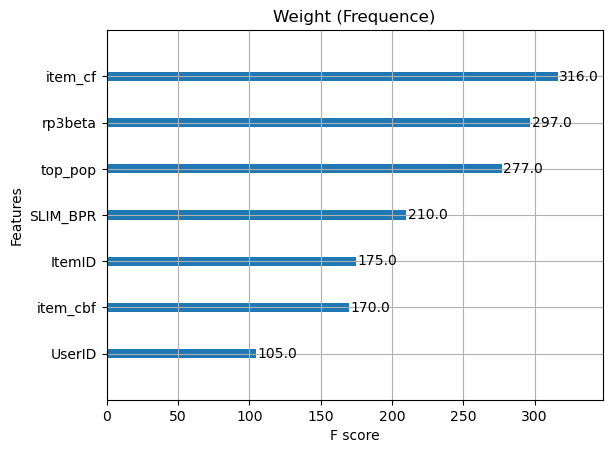

In [22]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [23]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [24]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [25]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-4.15653318e-01, -3.80444050e-01, -1.77042574e-01, -3.34050119e-01,
       -2.59669036e-01, -2.61394769e-01, -3.64055216e-01, -3.49155128e-01,
       -3.78662109e-01, -3.46304089e-01, -3.69437695e-01, -2.67032772e-01,
       -3.05242240e-01, -1.99784502e-01, -1.63087770e-02, -2.50838488e-01,
       -1.90633237e-01,  3.13986748e-01,  2.01428130e-01,  5.59336171e-02,
       -4.08253341e-04, -1.15818255e-01, -9.64099020e-02, -3.31272595e-02,
       -2.24182248e-01, -1.90681696e-01, -4.08253341e-04, -2.02806935e-01,
       -3.10294658e-01, -9.79869366e-02], dtype=float32)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

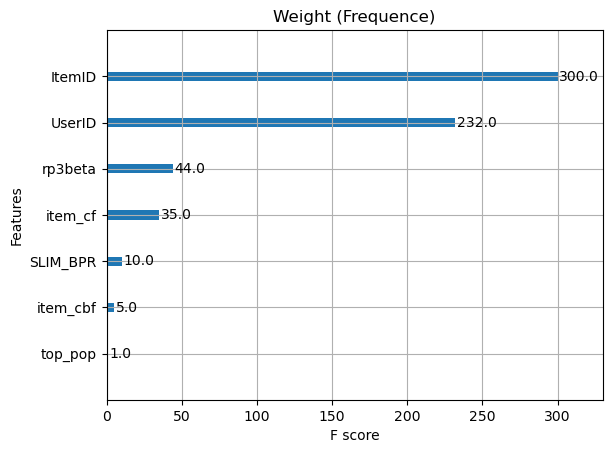

In [26]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [27]:
slim1 = SLIMElasticNetRecommender(URM_all)
slim1.load_model(folder_path="_saved_models", file_name="SLIM_ElasticNetAll")
stacked = sps.vstack([0.6814451172353111 * URM_all, (1 - 0.6814451172353111) * controller.ICM_all.T]).tocsr()
slim2 = SLIMElasticNetRecommender(stacked)
slim2.load_model(folder_path="_saved_models", file_name="SLIMstackedAll1")
bestrp3 = RP3betaRecommender(URM_all)
bestrp3.fit(topK= 12 , alpha = 0.25843, beta= 0.357834)
hyb1 = HybridOptunable2(URM_all)
hyb1.fit(0.27959722573911727,slim1,slim2)
ease1 = EASE_R_Recommender(URM_all)
ease1.load_model(folder_path="_saved_models", file_name="easeall")
hyb2 = HybridOptunable2(URM_all)
hyb2.fit(0.18923840370620948,hyb1,bestrp3)
hyb3 = ScoresHybridRecommender(controller.URM_train, ease1, hyb2, bestrp3, slim1, slim1)
alpha=0.689217356
hyb3.fit(alpha,1-alpha,0,0,0)

SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIM_ElasticNetAll'
SLIMElasticNetRecommender: Loading complete
SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIMstackedAll1'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Similarity column 38121 (100.0%), 2447.99 column/sec. Elapsed time 15.57 sec
EASE_R_Recommender: Loading model from file '_saved_modelseaseall'
EASE_R_Recommender: Loading complete


In [30]:
user_recommendations_items = []
user_recommendations_user_id = []

for user_id in tqdm(range(n_users)):
    recommendations = hyb3.recommend(user_id, cutoff = cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([user_id]*len(recommendations))

100%|██████████| 35736/35736 [03:07<00:00, 190.21it/s]


In [36]:
test_dataframe = pd.DataFrame({"UserID":user_recommendations_user_id, "ItemID":user_recommendations_items})
test_dataframe

,UserID,ItemID
0,0,2548
1,0,2697
2,0,7547
3,0,9911
4,0,14888
...,...,...
1072075,35735,36780
1072076,35735,37192
1072077,35735,35712
1072078,35735,36779


In [37]:
top_pop = TopPop(URM_all)
top_pop.fit()
item_cf = ItemKNNCFRecommender(URM_all)
item_cf.fit(similarity= 'tversky', topK= 5, shrink= 19, tversky_alpha= 0.20343700501082568, tversky_beta= 1.8980319969315242)
item_cbf = ItemKNNCBFRecommender(URM_all, ICM_all)
item_cbf.load_model(folder_path="_saved_models", file_name="ItemKNNCBFRecommender_all")
SLIM_BPR = SLIM_BPR_Cython(URM_all)
rp3beta=bestrp3

other_algorithms_all = {
    "top_pop": top_pop,
    "item_cf": item_cf,
    "item_cbf": item_cbf,
    "rp3beta": rp3beta,
    "SLIM_BPR": slimbpr
}

Cython module imported successfully.
Similarity column 38121 (100.0%), 1799.84 column/sec. Elapsed time 21.18 sec
ItemKNNCBFRecommender: Loading model from file '_saved_modelsItemKNNCBFRecommender_all'
ItemKNNCBFRecommender: Loading complete


In [ ]:

test_dataframe = test_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms_all.items():

        item_list = test_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "UserID"})




  2%|▏         | 753/35736 [00:58<45:27, 12.83it/s]

In [ ]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
test_dataframe['item_popularity'] = item_popularity[test_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
test_dataframe['user_profile_len'] = user_popularity[test_dataframe["UserID"].values.astype(int)]

test_dataframe

In [ ]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

In [ ]:
X = test_dataframe


In [ ]:
predictions = XGB_model.predict(X)
predictions

In [ ]:
reranked_dataframe = test_dataframe.copy()
reranked_dataframe['rating_xgb'] = pd.Series(predictions, index=reranked_dataframe.index)
reranked_dataframe

In [ ]:
reranked_dataframe = reranked_dataframe.sort_values(['UserID','rating_xgb'], ascending=[True, False])
reranked_dataframe

In [ ]:
def write_reranked_recommendations(file_name):
    recommendations = 'user_id,item_list'
    f = open(file_name + ".csv", "w")

    for user_id in tqdm(range(n_users)):
        recommendations_per_user = reranked_dataframe.loc[reranked_dataframe['UserID'] == user_id].ItemID.values[:10]

      


    f.write(recommendations_per_user)
    f.close()

In [ ]:
write_reranked_recommendations(file_name = "recomm")


In [ ]:

submission = pd.read_csv("recomm.csv")
submission